In [1]:
import sys

sys.path.append('../xor_neuron')

In [2]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt

In [3]:
import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch
from scipy.signal import convolve2d, fftconvolve, convolve
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

from model import *
from utils.train_helper import save_outphase, make_mask, load_model

In [4]:
dirs_conv_mnist = glob('../Control_activation_fnc_EXP/Conv/MNIST/*')
dirs_conv_mnist.sort(key=os.path.abspath)
dirs_conv_mnist

['../Control_activation_fnc_EXP/Conv/MNIST/CELU',
 '../Control_activation_fnc_EXP/Conv/MNIST/ELU',
 '../Control_activation_fnc_EXP/Conv/MNIST/GELU',
 '../Control_activation_fnc_EXP/Conv/MNIST/LeakyReLU',
 '../Control_activation_fnc_EXP/Conv/MNIST/PReLU',
 '../Control_activation_fnc_EXP/Conv/MNIST/ReLU',
 '../Control_activation_fnc_EXP/Conv/MNIST/SELU',
 '../Control_activation_fnc_EXP/Conv/MNIST/SiLU']

In [5]:
dirs_conv_cifar10 = glob('../Control_activation_fnc_EXP/Conv/CIFAR10/*')
dirs_conv_cifar10.sort(key=os.path.abspath)
dirs_conv_cifar10

['../Control_activation_fnc_EXP/Conv/CIFAR10/CELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/ELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/GELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/LeakyReLU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/PReLU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/ReLU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/SELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR10/SiLU']

In [6]:
dirs_mlp_mnist = glob('../Control_activation_fnc_EXP/MLP/MNIST/*')
dirs_mlp_mnist.sort(key=os.path.abspath)
dirs_mlp_mnist

['../Control_activation_fnc_EXP/MLP/MNIST/CELU',
 '../Control_activation_fnc_EXP/MLP/MNIST/ELU',
 '../Control_activation_fnc_EXP/MLP/MNIST/GELU',
 '../Control_activation_fnc_EXP/MLP/MNIST/LeakyReLU',
 '../Control_activation_fnc_EXP/MLP/MNIST/PReLU',
 '../Control_activation_fnc_EXP/MLP/MNIST/ReLU',
 '../Control_activation_fnc_EXP/MLP/MNIST/SELU',
 '../Control_activation_fnc_EXP/MLP/MNIST/SiLU']

In [7]:
dirs_mlp_cifar10 = glob('../Control_activation_fnc_EXP/MLP/CIFAR10/*')
dirs_mlp_cifar10.sort(key=os.path.abspath)
dirs_mlp_cifar10

['../Control_activation_fnc_EXP/MLP/CIFAR10/CELU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/ELU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/GELU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/LeakyReLU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/PReLU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/ReLU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/SELU',
 '../Control_activation_fnc_EXP/MLP/CIFAR10/SiLU']

In [8]:
dirs_conv_cifar100 = glob('../Control_activation_fnc_EXP/Conv/CIFAR100/*')
dirs_conv_cifar100.sort(key=os.path.abspath)
dirs_conv_cifar100

['../Control_activation_fnc_EXP/Conv/CIFAR100/CELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/ELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/GELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/LeakyReLU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/PReLU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/ReLU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/SELU',
 '../Control_activation_fnc_EXP/Conv/CIFAR100/SiLU']

In [9]:
def get_avg_std(dirs):
    std = []
    avg_acc = np.zeros(200)

    for ii, dr in enumerate(glob(dirs)):
        phase1_file = glob(dr + '/control_train_stats.p')[0]
        phase1_data = pickle.load(open(phase1_file, 'rb'))

        std.append(torch.Tensor(phase1_data['val_acc']))
        avg_acc += np.array(phase1_data['val_acc'])

    control_avg_acc = avg_acc / len(glob(dirs)) * 100

    std_control = torch.stack([std[0], std[1], std[2], std[3]])
    std_control = torch.std(std_control, dim=0).numpy()
    std_control = std_control * 100 /2
    
    return control_avg_acc, std_control

In [20]:
dirs = dirs_conv_cifar100

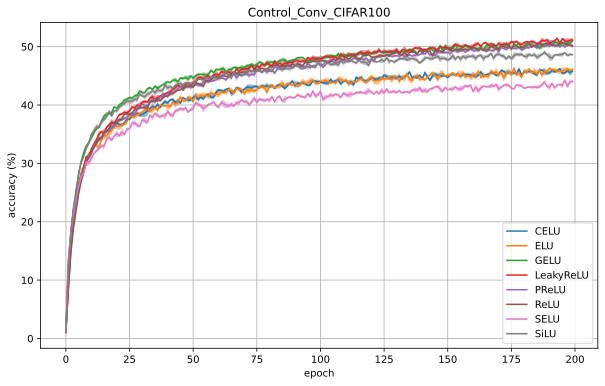

In [21]:
f, ax = plt.subplots(figsize=(10,6))

title = ['Control'] + dirs[0].split('/')[-3:-1]
title = '_'.join(title)

epoch = np.arange(200)
for act_fnc in dirs:
    act_name = act_fnc.split('/')[-1]    
    avg_acc, std = get_avg_std(act_fnc+'/*')
    
    ax.plot(epoch, avg_acc,label = act_name)
    ax.fill_between(epoch, avg_acc+std, avg_acc-std, alpha=0.5)
    
# ax.set_ylim(98,100)
# ax.set_yticks([98, 99, 100])
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy (%)')
    
ax.grid(True)
ax.legend()
ax.set_title(title)

f.savefig(f'./{title}.pdf')